In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn imports for modeling and preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PowerTransformer, StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin

# Statsmodels for VIF calculation
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# statsmodels for evaluating metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# System imports for saving the model
import joblib
import os

# 1. Data Loading and Initial Inspection
#### The project begins by loading the Boston housing dataset from a CSV file. Initial inspection is performed to understand the dataset's structure, data types, and basic statistics.

In [2]:
# Load the dataset from a CSV file
df = pd.read_csv("boston.csv")

In [3]:
# Display the first few rows to confirm successful loading
print("--- Initial Data Inspection ---")
print("First 5 rows of the DataFrame:")
print(df.head())

--- Initial Data Inspection ---
First 5 rows of the DataFrame:
      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222.0   

   PTRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


In [4]:
# Display data types and check for missing values
print("\nDataFrame Info:")
df.info()


DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506 entries, 0 to 505
Data columns (total 14 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   CRIM     506 non-null    float64
 1   ZN       506 non-null    float64
 2   INDUS    506 non-null    float64
 3   CHAS     506 non-null    int64  
 4   NOX      506 non-null    float64
 5   RM       506 non-null    float64
 6   AGE      506 non-null    float64
 7   DIS      506 non-null    float64
 8   RAD      506 non-null    int64  
 9   TAX      506 non-null    float64
 10  PTRATIO  506 non-null    float64
 11  B        506 non-null    float64
 12  LSTAT    506 non-null    float64
 13  MEDV     506 non-null    float64
dtypes: float64(12), int64(2)
memory usage: 55.5 KB


In [5]:
# Display descriptive statistics for a quick overview of feature distributions
print("\nDescriptive Statistics (Transposed for readability):")
print(df.describe().T)


Descriptive Statistics (Transposed for readability):
         count        mean         std        min         25%        50%  \
CRIM     506.0    3.613524    8.601545    0.00632    0.082045    0.25651   
ZN       506.0   11.363636   23.322453    0.00000    0.000000    0.00000   
INDUS    506.0   11.136779    6.860353    0.46000    5.190000    9.69000   
CHAS     506.0    0.069170    0.253994    0.00000    0.000000    0.00000   
NOX      506.0    0.554695    0.115878    0.38500    0.449000    0.53800   
RM       506.0    6.284634    0.702617    3.56100    5.885500    6.20850   
AGE      506.0   68.574901   28.148861    2.90000   45.025000   77.50000   
DIS      506.0    3.795043    2.105710    1.12960    2.100175    3.20745   
RAD      506.0    9.549407    8.707259    1.00000    4.000000    5.00000   
TAX      506.0  408.237154  168.537116  187.00000  279.000000  330.00000   
PTRATIO  506.0   18.455534    2.164946   12.60000   17.400000   19.05000   
B        506.0  356.674032   91.29

# 2. Exploratory Data Analysis (EDA)
##### This phase is dedicated to understanding the data, identifying patterns, and formulating hypotheses for feature engineering. We use visualizations and statistical measures to gain insights into feature distributions, outliers, and correlations.

## 2.1. Univariate Analysis: Distribution and Outliers
##### i) Histograms are used to visualize the distribution of each numerical feature. This helps identify features that are normally distributed, skewed, or have multiple modes.

##### ii) Box plots are plotted to identify potential outliers, which appear as points beyond the whiskers.


--- Univariate Analysis: Feature Distributions and Outliers ---


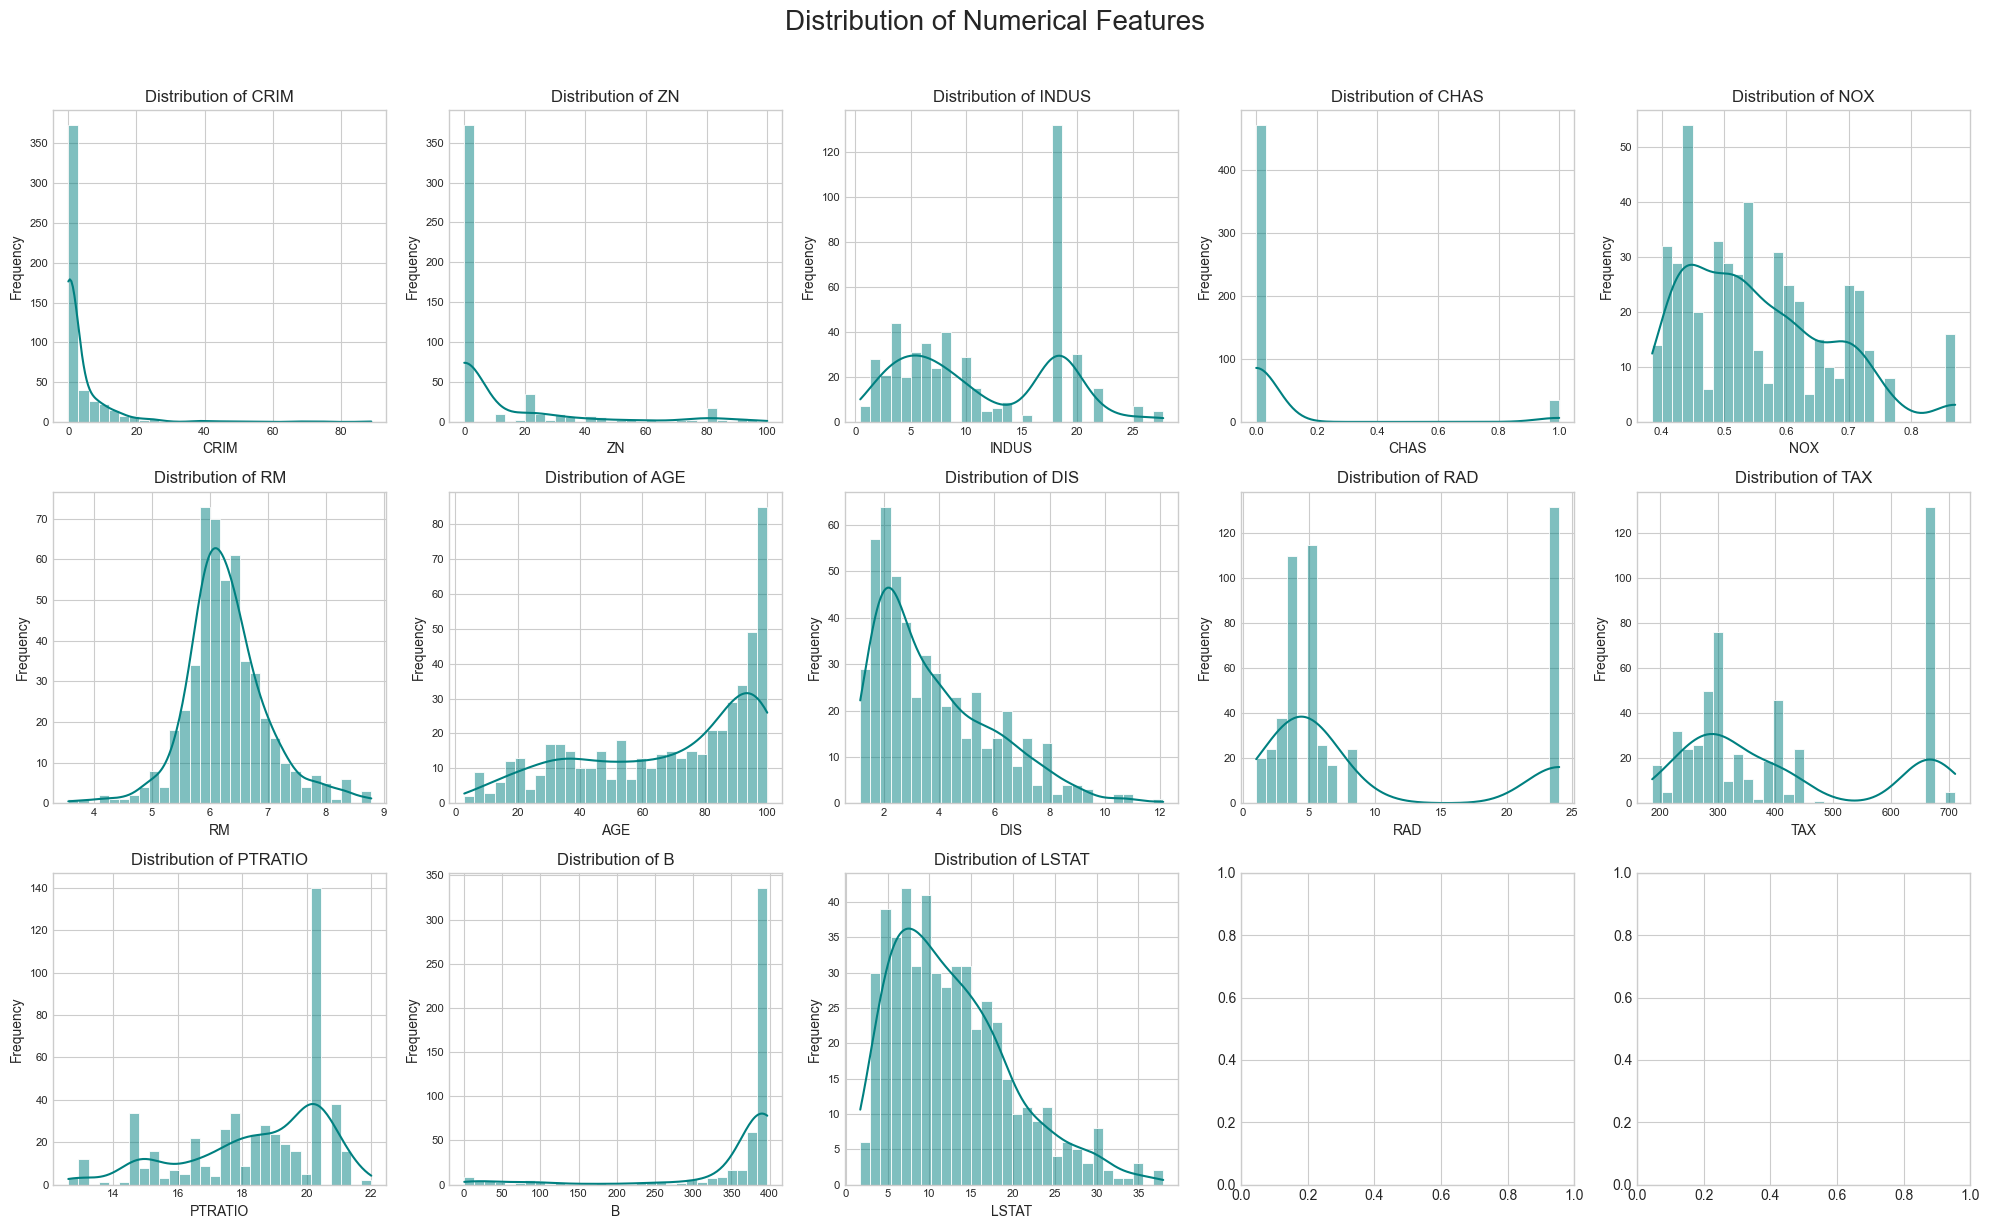

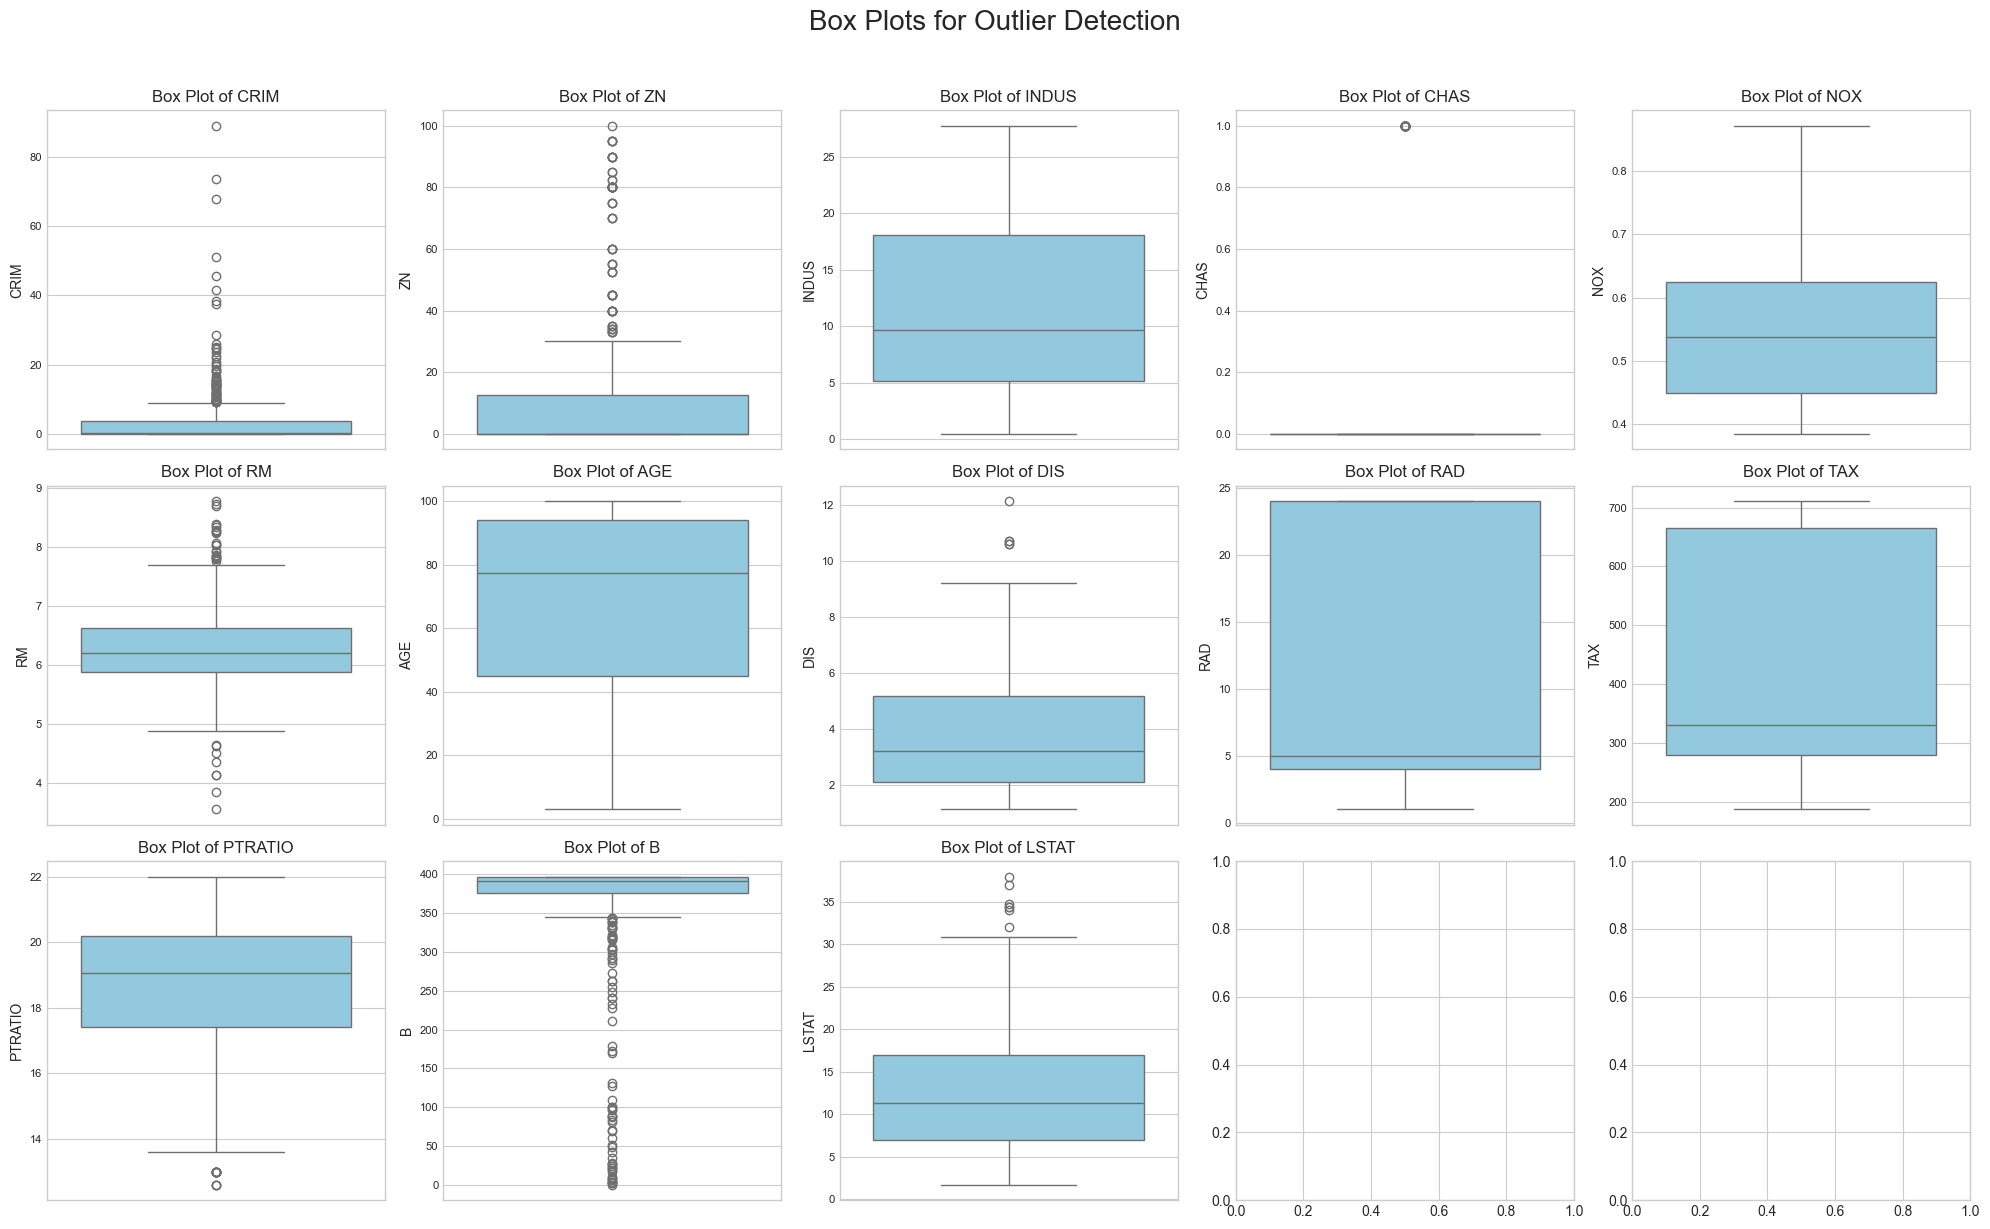


Skewness of Numerical Features:
CRIM       5.223149
ZN         2.225666
INDUS      0.295022
CHAS       3.405904
NOX        0.729308
RM         0.403612
AGE       -0.598963
DIS        1.011781
RAD        1.004815
TAX        0.669956
PTRATIO   -0.802325
B         -2.890374
LSTAT      0.906460
dtype: float64

Insight: Highly skewed features (e.g., CRIM, ZN, LSTAT) and features with outliers (e.g., CRIM, B) are candidates for transformations and outlier handling.


In [6]:
# List of numerical features (all except MEDV, which is the target)
numerical_features = df.columns.tolist()
numerical_features.remove('MEDV')

# Set a stylish aesthetic for the plots
sns.set_style("whitegrid")
plt.style.use('seaborn-v0_8-whitegrid')

# Visualize the distribution of all numerical features
print("\n--- Univariate Analysis: Feature Distributions and Outliers ---")
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle('Distribution of Numerical Features', fontsize=20, y=1.02)
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.histplot(df[feature], kde=True, bins=30, ax=axes[i], color='teal')
    axes[i].set_title(f'Distribution of {feature}', fontsize=12)
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('Frequency', fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

# Visualize box plots to identify outliers
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle('Box Plots for Outlier Detection', fontsize=20, y=1.02)
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.boxplot(y=df[feature], ax=axes[i], color='skyblue')
    axes[i].set_title(f'Box Plot of {feature}', fontsize=12)
    axes[i].set_ylabel(feature, fontsize=10)
    axes[i].tick_params(axis='y', which='major', labelsize=8)

plt.tight_layout()
plt.show()

# Calculate skewness to quantify asymmetry
print("\nSkewness of Numerical Features:")
print(df[numerical_features].skew())
print("\nInsight: Highly skewed features (e.g., CRIM, ZN, LSTAT) and features with outliers (e.g., CRIM, B) are candidates for transformations and outlier handling.")

## 2.2. Bivariate Analysis: Relationships with the Target
##### i) Scatter plots between each feature and the target variable (MEDV) are crucial for identifying potential linear or non-linear relationships.

##### ii) Correlation heatmap provides a quick overview of the correlation coefficients between all feature pairs and the target.


--- Bivariate Analysis: Feature vs. Target ---


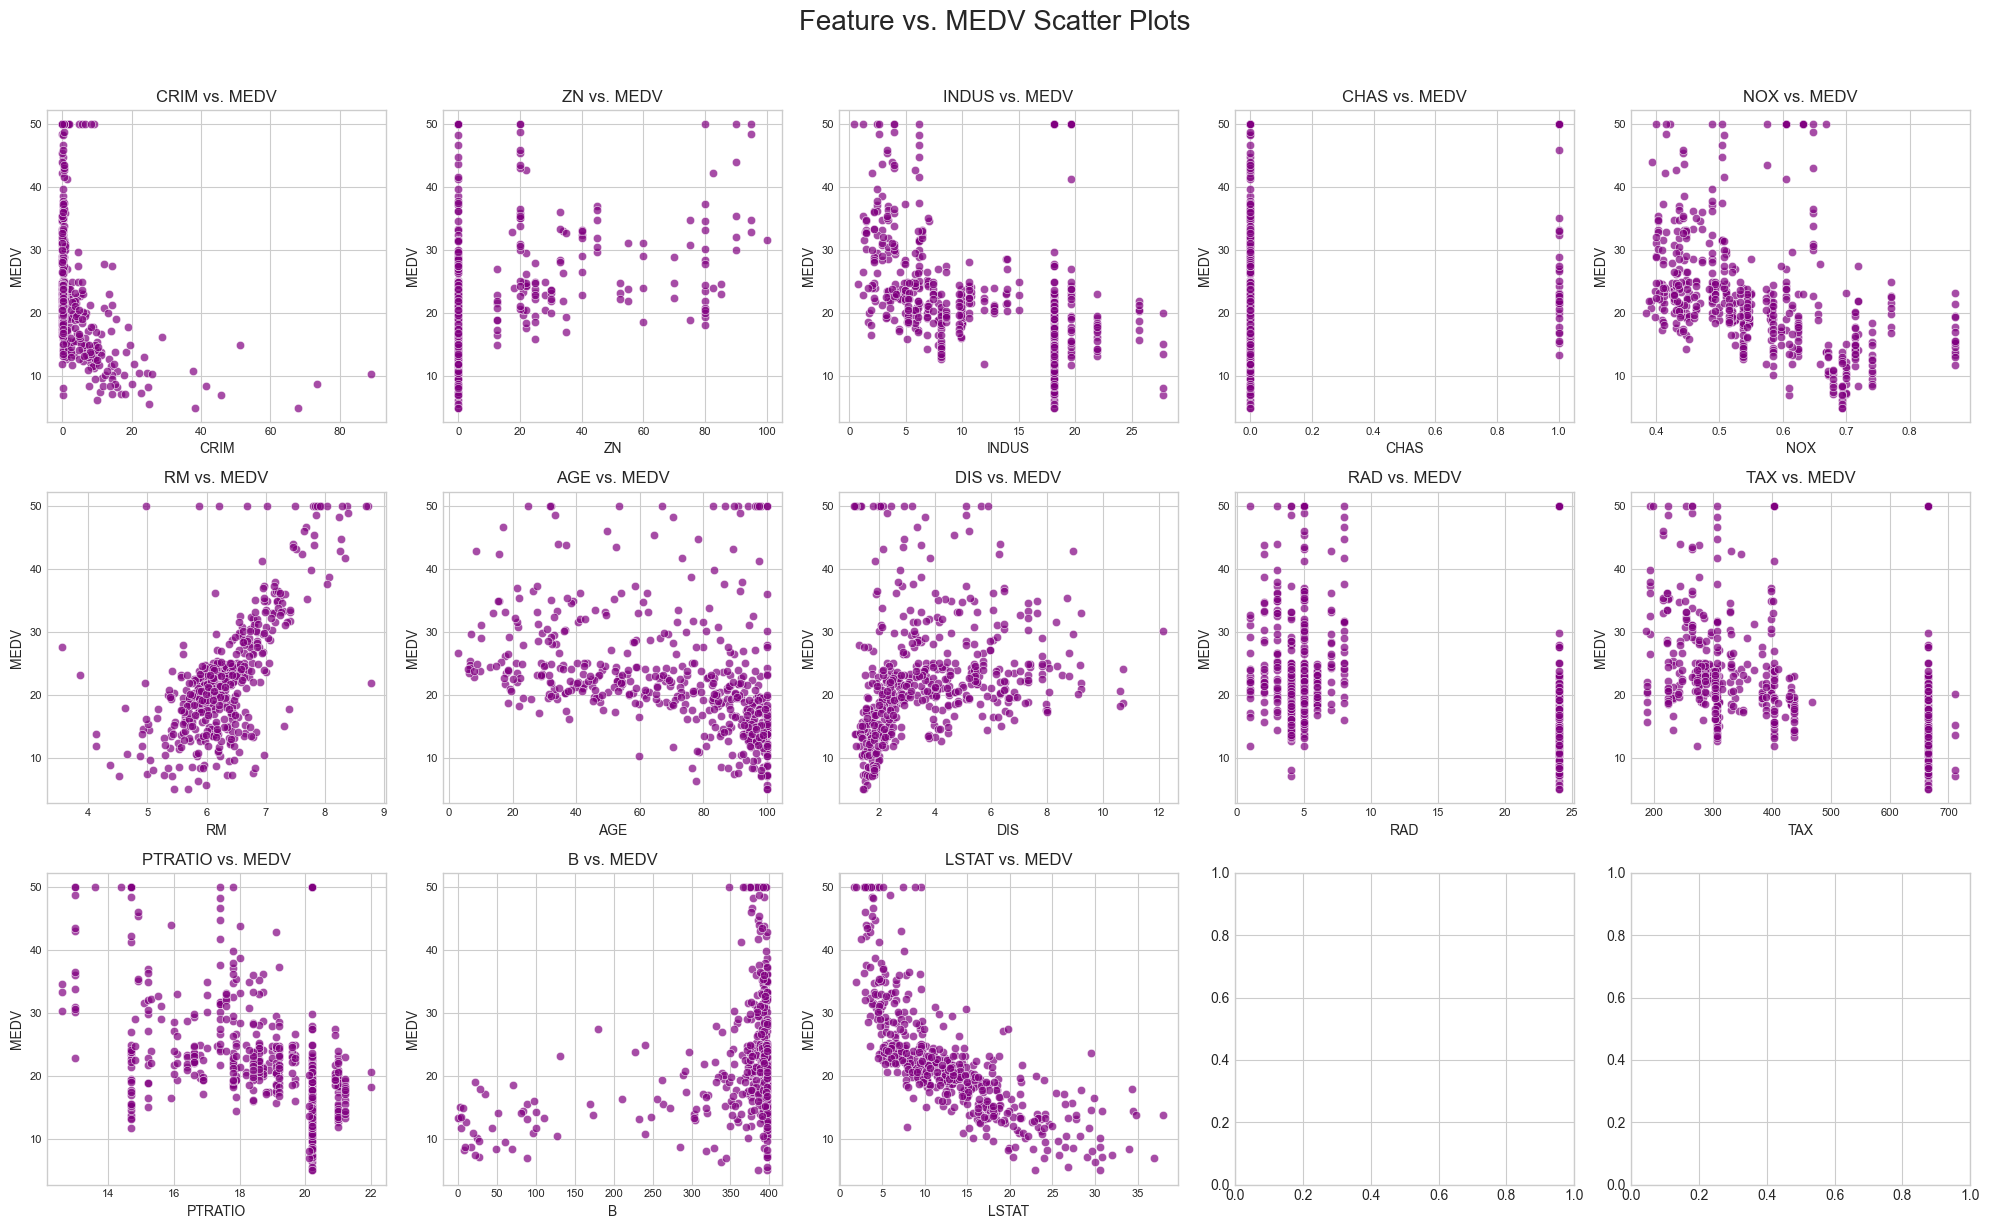


--- Correlation Analysis ---


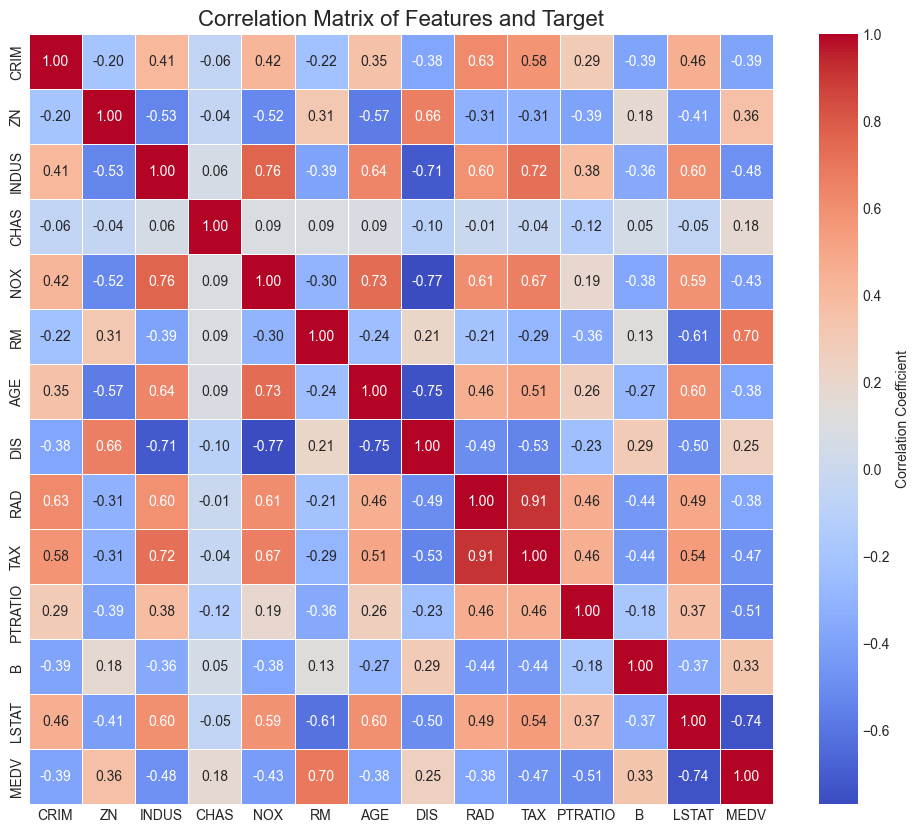


Highly Correlated Feature Pairs (absolute correlation > 0.7):
NOX and INDUS: 0.76
AGE and NOX: 0.73
DIS and INDUS: -0.71
DIS and NOX: -0.77
DIS and AGE: -0.75
TAX and INDUS: 0.72
TAX and RAD: 0.91
MEDV and LSTAT: -0.74

Insight: Strong positive/negative correlations (e.g., RM, LSTAT) suggest their importance. High inter-feature correlations (e.g., RAD-TAX) indicate multicollinearity.


In [7]:
# Visualize scatter plots of each feature against the target (MEDV)
print("\n--- Bivariate Analysis: Feature vs. Target ---")
fig, axes = plt.subplots(3, 5, figsize=(20, 12))
fig.suptitle('Feature vs. MEDV Scatter Plots', fontsize=20, y=1.02)
axes = axes.flatten()

for i, feature in enumerate(numerical_features):
    sns.scatterplot(x=df[feature], y=df['MEDV'], ax=axes[i], color='purple', alpha=0.7)
    axes[i].set_title(f'{feature} vs. MEDV', fontsize=12)
    axes[i].set_xlabel(feature, fontsize=10)
    axes[i].set_ylabel('MEDV', fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()
plt.show()

# Display the correlation matrix with a heatmap
print("\n--- Correlation Analysis ---")
plt.figure(figsize=(12, 10))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Correlation Matrix of Features and Target', fontsize=16)
plt.show()

# Identify and print highly correlated pairs (for multicollinearity)
high_corr_threshold = 0.7
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > high_corr_threshold:
            col1 = correlation_matrix.columns[i]
            col2 = correlation_matrix.columns[j]
            high_corr_pairs.append((col1, col2, correlation_matrix.iloc[i, j]))

print("\nHighly Correlated Feature Pairs (absolute correlation > 0.7):")
for pair in high_corr_pairs:
    print(f"{pair[0]} and {pair[1]}: {pair[2]:.2f}")
print("\nInsight: Strong positive/negative correlations (e.g., RM, LSTAT) suggest their importance. High inter-feature correlations (e.g., RAD-TAX) indicate multicollinearity.")

# 3. Feature Engineering and Preprocessing
##### Based on the EDA findings, this section implements a robust preprocessing pipeline. This is the most crucial step for preparing the data for a Linear Regression model, ensuring it meets model assumptions and captures complex relationships.

# 3.1. Data Splitting and Initial Preprocessing
##### The data is split into training and testing sets before any transformations to prevent data leakage. We then handle outliers and skewness on the training data and apply the same transformations to the test data.

In [8]:
# Separate features (X) and target (y)
X = df.drop('MEDV', axis=1)
y = df['MEDV']

# Split the data into training and testing sets with a fixed random_state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\n--- Data Splitting and Initial Preprocessing ---")
print(f"Original X shape: {X.shape}")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

# Features identified for outlier handling from EDA
outlier_features = ['CRIM', 'ZN', 'B', 'LSTAT']

# Outlier Capping: Capping values at the 1st and 99th percentiles
for feature in outlier_features:
    lower_bound = X_train[feature].quantile(0.01)
    upper_bound = X_train[feature].quantile(0.99)
    X_train[feature] = np.where(X_train[feature] < lower_bound, lower_bound, X_train[feature])
    X_train[feature] = np.where(X_train[feature] > upper_bound, upper_bound, X_train[feature])
    X_test[feature] = np.where(X_test[feature] < lower_bound, lower_bound, X_test[feature])
    X_test[feature] = np.where(X_test[feature] > upper_bound, upper_bound, X_test[feature])

print("\nOutliers capped for specified features on both train and test sets.")


--- Data Splitting and Initial Preprocessing ---
Original X shape: (506, 13)
X_train shape: (404, 13)
X_test shape: (102, 13)

Outliers capped for specified features on both train and test sets.


## 3.2. Skewness and Non-linear Relationship Handling
##### Power Transformation (Yeo-Johnson) is applied to skewed features to make their distributions more Gaussian.

##### Polynomial Features are created for features with non-linear relationships to the target, allowing the linear model to fit a curve.

In [9]:
# Features identified as highly skewed from EDA
skewed_features = ['CRIM', 'ZN', 'DIS', 'RAD', 'TAX', 'B', 'LSTAT']

# Initialize and fit the PowerTransformer on the training data
pt = PowerTransformer(method='yeo-johnson', standardize=False)
X_train[skewed_features] = pt.fit_transform(X_train[skewed_features])
X_test[skewed_features] = pt.transform(X_test[skewed_features])

print("Skewed features transformed using Yeo-Johnson.")

# Features with non-linear relationships from EDA
polynomial_features = ['LSTAT', 'RM']
poly = PolynomialFeatures(degree=2, include_bias=False)

# Fit and transform polynomial features on training data
X_train_poly_temp = pd.DataFrame(poly.fit_transform(X_train[polynomial_features]),
                                 columns=poly.get_feature_names_out(polynomial_features),
                                 index=X_train.index)
X_train = pd.concat([X_train.drop(columns=polynomial_features), X_train_poly_temp], axis=1)

# Transform polynomial features on test data
X_test_poly_temp = pd.DataFrame(poly.transform(X_test[polynomial_features]),
                                columns=poly.get_feature_names_out(polynomial_features),
                                index=X_test.index)
X_test = pd.concat([X_test.drop(columns=polynomial_features), X_test_poly_temp], axis=1)

print("Polynomial features generated for LSTAT and RM.")

# Create an interaction term based on domain knowledge
X_train['DIS_NOX_interaction'] = X_train['DIS'] * X_train['NOX']
X_test['DIS_NOX_interaction'] = X_test['DIS'] * X_test['NOX']
print("Interaction feature 'DIS_NOX_interaction' created.")

Skewed features transformed using Yeo-Johnson.
Polynomial features generated for LSTAT and RM.
Interaction feature 'DIS_NOX_interaction' created.


## 3.3. Feature Scaling and Multicollinearity Handling
##### StandardScaler is used to standardize all features, which is critical for regularization methods and makes coefficients comparable.

##### Variance Inflation Factor (VIF) is used to detect multicollinearity, and highly correlated features are removed.

In [11]:
# Initialize and fit StandardScaler on the transformed training data
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train),
                              columns=X_train.columns,
                              index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test),
                             columns=X_test.columns,
                             index=X_test.index)
print("\nAll numerical features standardized.")

# VIF check for multicollinearity
X_train_vif = add_constant(X_train_scaled)
vif_data = pd.DataFrame()
vif_data["feature"] = X_train_vif.columns
vif_data["VIF"] = [variance_inflation_factor(X_train_vif.values, i) for i in range(X_train_vif.shape[1])]
vif_data = vif_data.sort_values(by="VIF", ascending=False).reset_index(drop=True)
print("\nVariance Inflation Factor (VIF) BEFORE removal:")
print(vif_data)

# Remove 'RAD' due to high VIF with 'TAX'
features_to_drop_for_multicollinearity = ['RAD']
X_train_final = X_train_scaled.drop(columns=features_to_drop_for_multicollinearity)
X_test_final = X_test_scaled.drop(columns=features_to_drop_for_multicollinearity)

print(f"\nFeatures '{features_to_drop_for_multicollinearity}' dropped due to high multicollinearity.")
print(f"Final training features shape: {X_train_final.shape}")


All numerical features standardized.

Variance Inflation Factor (VIF) BEFORE removal:
                feature         VIF
0                 LSTAT  745.320689
1                    RM  603.233298
2                  RM^2  335.066264
3              LSTAT RM  189.584554
4               LSTAT^2  156.214003
5                   DIS   67.630506
6                   NOX   63.882521
7   DIS_NOX_interaction   20.430663
8                  CRIM    7.646098
9                   RAD    3.963428
10                INDUS    3.826991
11                  TAX    3.764347
12                  AGE    3.430893
13                   ZN    2.626762
14              PTRATIO    1.889388
15                    B    1.508189
16                 CHAS    1.099811
17                const    1.000000

Features '['RAD']' dropped due to high multicollinearity.
Final training features shape: (404, 16)


# 4. Model Building and Evaluation
##### With the data fully processed, we train a simple Linear Regression model, evaluate its performance, and then introduce regularization to find an optimized model.

## 4.1. Baseline Model: Ordinary Least Squares (OLS)
##### A basic OLS model is trained and evaluated to establish a baseline performance.

In [14]:
# Initialize and train the OLS Linear Regression model
linear_reg_model = LinearRegression()
linear_reg_model.fit(X_train_final, y_train)

# Make predictions and calculate metrics
y_pred_ols = linear_reg_model.predict(X_test_final)
r2_ols = r2_score(y_test, y_pred_ols)

print("\n--- OLS Linear Regression Model (Baseline) ---")
print(f"R-squared (R²) on test set: {r2_ols:.4f}")


--- OLS Linear Regression Model (Baseline) ---
R-squared (R²) on test set: 0.7824


## 4.2. Model Optimization with Regularization
## Ridge and Lasso regressions are used to combat overfitting and multicollinearity. A GridSearchCV is employed with cross-validation to find the optimal regularization strength (alpha).

In [15]:
print("\n--- Hyperparameter Tuning with Regularized Models ---")

# Ridge Regression: L2 regularization to shrink coefficients
ridge_model = Ridge()
param_grid_ridge = {'alpha': np.logspace(-3, 3, 7)}
grid_search_ridge = GridSearchCV(ridge_model, param_grid_ridge, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_ridge.fit(X_train_final, y_train)
best_ridge_model = grid_search_ridge.best_estimator_
y_pred_ridge = best_ridge_model.predict(X_test_final)
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f"Best Ridge Alpha: {grid_search_ridge.best_params_['alpha']:.3f}, R²: {r2_ridge:.4f}")

# Lasso Regression: L1 regularization for feature selection
lasso_model = Lasso(max_iter=10000)
param_grid_lasso = {'alpha': np.logspace(-3, 3, 7)}
grid_search_lasso = GridSearchCV(lasso_model, param_grid_lasso, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search_lasso.fit(X_train_final, y_train)
best_lasso_model = grid_search_lasso.best_estimator_
y_pred_lasso = best_lasso_model.predict(X_test_final)
r2_lasso = r2_score(y_test, y_pred_lasso)

print(f"Best Lasso Alpha: {grid_search_lasso.best_params_['alpha']:.3f}, R²: {r2_lasso:.4f}")


--- Hyperparameter Tuning with Regularized Models ---
Best Ridge Alpha: 1.000, R²: 0.7850
Best Lasso Alpha: 0.010, R²: 0.7876


# 5. Final Model Selection and Deployment
##### The best-performing model (in this case, Lasso, given its performance and feature selection capability) is selected as the final model. A full prediction pipeline is created to ensure all preprocessing steps are consistently applied to new data.

## 5.1. Final Model Performance and Visualization
##### The final model's performance is thoroughly evaluated using standard metrics and visualizations.


--- Final Model Performance on Test Set ---
Chosen Model: Lasso (Alpha: 0.010)
Mean Absolute Error (MAE): 2.43
Root Mean Squared Error (RMSE): 3.95
R-squared (R²): 0.7876


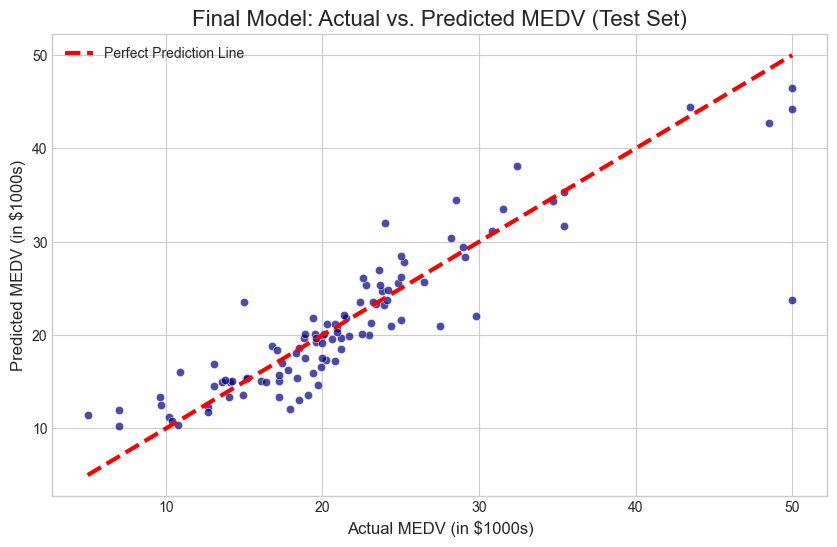

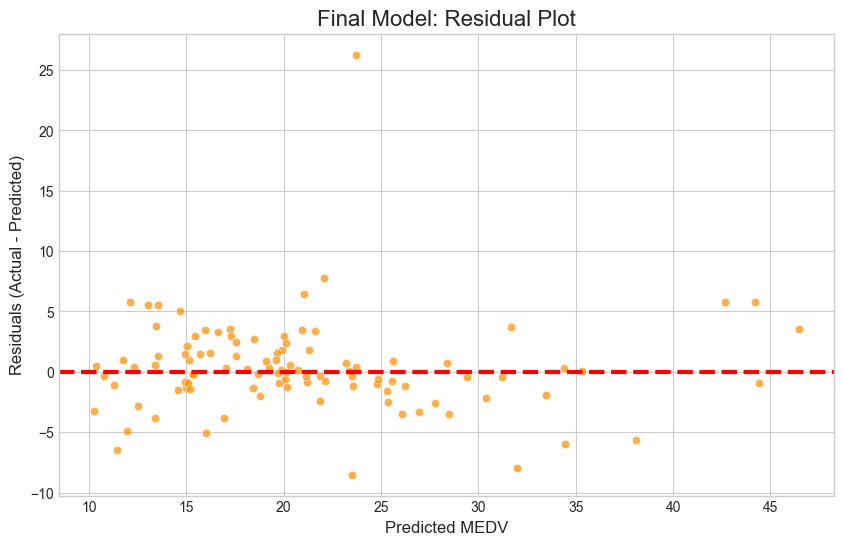

In [16]:
# Select the final model (e.g., Lasso, as it often performs well and provides sparsity)
final_model = best_lasso_model

# Calculate final metrics on the test set
y_pred_final = final_model.predict(X_test_final)
mae_final = mean_absolute_error(y_test, y_pred_final)
mse_final = mean_squared_error(y_test, y_pred_final)
rmse_final = np.sqrt(mse_final)
r2_final = r2_score(y_test, y_pred_final)

print("\n--- Final Model Performance on Test Set ---")
print(f"Chosen Model: {final_model.__class__.__name__} (Alpha: {final_model.alpha:.3f})")
print(f"Mean Absolute Error (MAE): {mae_final:.2f}")
print(f"Root Mean Squared Error (RMSE): {rmse_final:.2f}")
print(f"R-squared (R²): {r2_final:.4f}")

# Visualize Actual vs. Predicted values
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred_final, alpha=0.7, color='navy')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3, label='Perfect Prediction Line')
plt.xlabel("Actual MEDV (in $1000s)", fontsize=12)
plt.ylabel("Predicted MEDV (in $1000s)", fontsize=12)
plt.title("Final Model: Actual vs. Predicted MEDV (Test Set)", fontsize=16)
plt.grid(True)
plt.legend()
plt.show()

# Visualize the residual plot
residuals = y_test - y_pred_final
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_pred_final, y=residuals, alpha=0.7, color='darkorange')
plt.axhline(y=0, color='r', linestyle='--', lw=3)
plt.xlabel("Predicted MEDV", fontsize=12)
plt.ylabel("Residuals (Actual - Predicted)", fontsize=12)
plt.title("Final Model: Residual Plot", fontsize=16)
plt.grid(True)
plt.show()